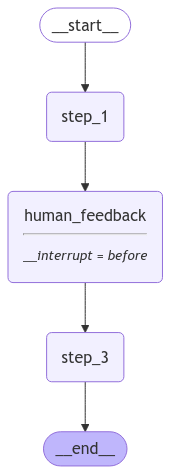

In [1]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from IPython.display import Image, display


class State(TypedDict):
    input: str
    user_feedback: str


def step_1(state):
    print("---Step 1---")
    pass


def human_feedback(state):
    print("---human_feedback---")
    pass


def step_3(state):
    print("---Step 3---")
    pass


builder = StateGraph(State)
builder.add_node("step_1", step_1)
builder.add_node("human_feedback", human_feedback)
builder.add_node("step_3", step_3)
builder.add_edge(START, "step_1")
builder.add_edge("step_1", "human_feedback")
builder.add_edge("human_feedback", "step_3")
builder.add_edge("step_3", END)

# Set up memory
memory = MemorySaver()

# Add
graph = builder.compile(checkpointer=memory, interrupt_before=["human_feedback"])

# View
display(Image(graph.get_graph().draw_mermaid_png()))


In [2]:
# Input
initial_input = {"input": "hello world"}

# Thread
thread = {"configurable": {"thread_id": "1"}}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    print(event)

{'input': 'hello world'}
---Step 1---


In [4]:
# Get user input
try:
    user_input = input("Tell me how you want to update the state: ")
except:
    user_input = "go to step 3!"

# We now update the state as if we are the human_feedback node
graph.update_state(thread, {"user_feedback": user_input}, as_node="human_feedback")

# We can check the state
print("--State after update--")
print(graph.get_state(thread))

# We can check the next node, showing that it is node 3 (which follows human_feedback)
graph.get_state(thread).next

--State after update--
StateSnapshot(values={'input': 'hello world', 'user_feedback': 'go to step 2!'}, next=('step_3',), config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb3404-7cbe-60da-8003-ce9d250571e3'}}, metadata={'source': 'update', 'writes': {'human_feedback': {'user_feedback': 'go to step 2!'}}, 'thread_id': '1', 'step': 3, 'parents': {}}, created_at='2024-12-05T19:36:53.559649+00:00', parent_config={'configurable': {'thread_id': '1', 'checkpoint_ns': '', 'checkpoint_id': '1efb3403-a3d6-6efb-8002-45dc77ab8718'}}, tasks=(PregelTask(id='4f944c38-a925-7c71-604f-ec0f155faaac', name='step_3', path=('__pregel_pull', 'step_3'), error=None, interrupts=(), state=None, result=None),))


('step_3',)

In [5]:
for event in graph.stream(None, thread, stream_mode="values"):
    print(event)

{'input': 'hello world', 'user_feedback': 'go to step 2!'}
---Step 3---


---

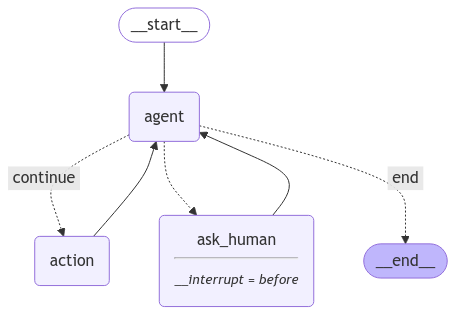

In [6]:
# Set up the state
from langgraph.graph import MessagesState, START

# Set up the tool
# We will have one real tool - a search tool
# We'll also have one "fake" tool - a "ask_human" tool
# Here we define any ACTUAL tools
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode


@tool
def search(query: str):
    """Call to surf the web."""
    # This is a placeholder for the actual implementation
    # Don't let the LLM know this though 😊
    return f"I looked up: {query}. Result: It's sunny in San Francisco, but you better look out if you're a Gemini 😈."


tools = [search]
tool_node = ToolNode(tools)

# Set up the model
from langchain_groq import ChatGroq
from LegalDefAgent.src.models import _get_model

model = _get_model('groq')

from pydantic import BaseModel


# We are going "bind" all tools to the model
# We have the ACTUAL tools from above, but we also need a mock tool to ask a human
# Since `bind_tools` takes in tools but also just tool definitions,
# We can define a tool definition for `ask_human`
class AskHuman(BaseModel):
    """Ask the human a question"""

    question: str


model = model.bind_tools(tools + [AskHuman])

# Define nodes and conditional edges


# Define the function that determines whether to continue or not
def should_continue(state):
    messages = state["messages"]
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # If tool call is asking Human, we return that node
    # You could also add logic here to let some system know that there's something that requires Human input
    # For example, send a slack message, etc
    elif last_message.tool_calls[0]["name"] == "AskHuman":
        return "ask_human"
    # Otherwise if there is, we continue
    else:
        return "continue"


# Define the function that calls the model
def call_model(state):
    messages = state["messages"]
    response = model.invoke(messages)
    # We return a list, because this will get added to the existing list
    return {"messages": [response]}


# We define a fake node to ask the human
def ask_human(state):
    pass


# Build the graph

from langgraph.graph import END, StateGraph

# Define a new graph
workflow = StateGraph(MessagesState)

# Define the three nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("action", tool_node)
workflow.add_node("ask_human", ask_human)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.add_edge(START, "agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # We may ask the human
        "ask_human": "ask_human",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

# After we get back the human response, we go back to the agent
workflow.add_edge("ask_human", "agent")

# Set up memory
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
# We add a breakpoint BEFORE the `ask_human` node so it never executes
app = workflow.compile(checkpointer=memory, interrupt_before=["ask_human"])

display(Image(app.get_graph().draw_mermaid_png()))

In [8]:
from langchain_core.messages import HumanMessage

config = {"configurable": {"thread_id": "2"}}
input_message = HumanMessage(
    content="Use the search tool to ask the user where they are, then look up the weather there"
)
for event in app.stream({"messages": [input_message]}, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================ Human Message =================================

Use the search tool to ask the user where they are, then look up the weather there
================================== Ai Message ==================================
Tool Calls:
  AskHuman (call_vknm)
 Call ID: call_vknm
  Args:
    question: Where are you located?


In [9]:
tool_call_id = app.get_state(config).values["messages"][-1].tool_calls[0]["id"]

# We now create the tool call with the id and the response we want
tool_message = [
    {"tool_call_id": tool_call_id, "type": "tool", "content": "san francisco"}
]

# # This is equivalent to the below, either one works
# from langchain_core.messages import ToolMessage
# tool_message = [ToolMessage(tool_call_id=tool_call_id, content="san francisco")]

# We now update the state
# Notice that we are also specifying `as_node="ask_human"`
# This will apply this update as this node,
# which will make it so that afterwards it continues as normal
app.update_state(config, {"messages": tool_message}, as_node="ask_human")

# We can check the state
# We can see that the state currently has the `agent` node next
# This is based on how we define our graph,
# where after the `ask_human` node goes (which we just triggered)
# there is an edge to the `agent` node
app.get_state(config).next

('agent',)

In [10]:
for event in app.stream(None, config, stream_mode="values"):
    event["messages"][-1].pretty_print()

================================= Tool Message =================================

san francisco
================================== Ai Message ==================================
Tool Calls:
  search (call_rx6r)
 Call ID: call_rx6r
  Args:
    query: weather in san francisco
================================= Tool Message =================================
Name: search

I looked up: weather in san francisco. Result: It's sunny in San Francisco, but you better look out if you're a Gemini 😈.
================================== Ai Message ==================================

It's sunny in San Francisco.
